In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Wind Power Forecasting Model Selection
## Features selection, train-val-test split

In [2]:
from sklearn.model_selection import train_test_split

import datetime as dt
import numpy as np
import time

import tools.plot_setup

import cache.wind_ls

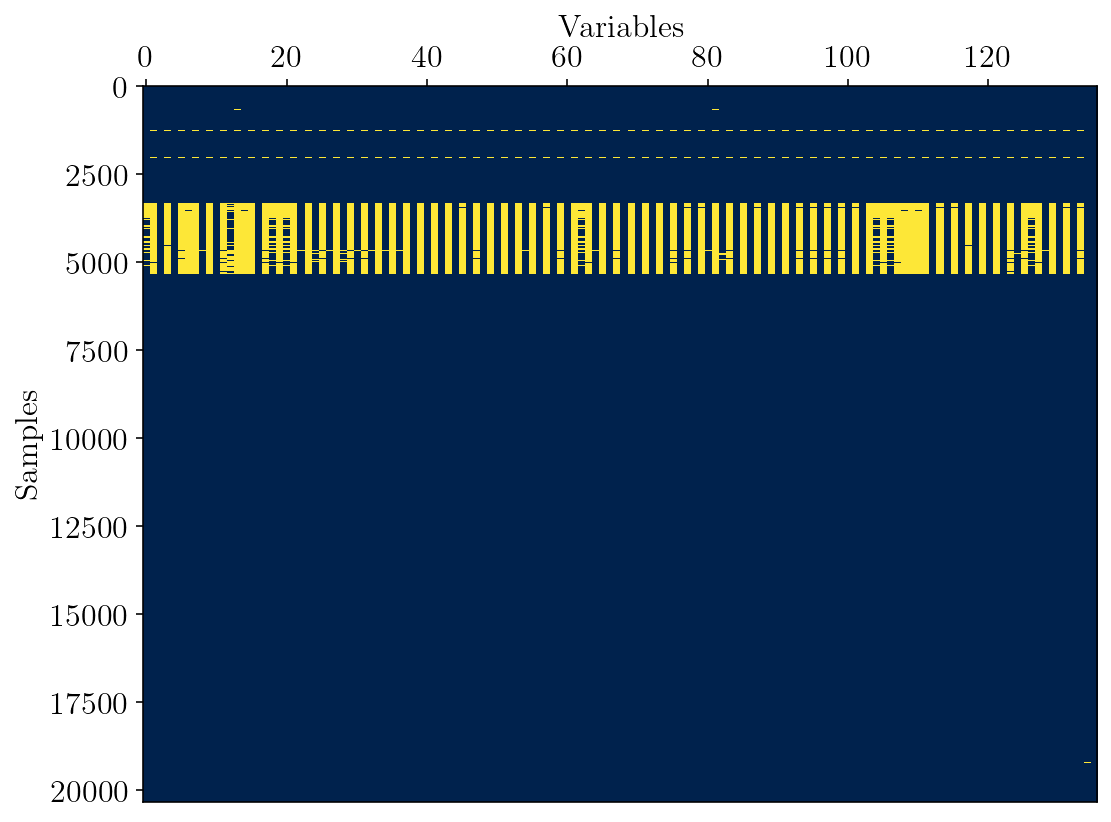

There were 2051 na values in the learning set
The learning set has been successfully cached


In [3]:
variables = ['wind_speed', 'wind_gust']
cache.wind_ls.cache_learning_set(show_na=True, test_set=False, variables=variables)

In [4]:
X, y, t = cache.wind_ls.get_learning_set()
X_LS, X_test, y_LS, y_test, t_LS, t_test = train_test_split(X, y, t, test_size=.25, random_state=0)
X_train, X_val, y_train, y_val, t_train, t_val = train_test_split(X_LS, y_LS, t_LS, test_size=.33, random_state=0)
print('Train set:', len(X_train))
print('Validation set:', len(X_val))
print('Test set:', len(X_test))

Train set: 9183
Validation set: 4524
Test set: 4569


## Models' performance and timing overview 

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error as mae

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators': [500, 1000, 2000]
}

for params in ParameterGrid(parameters):
    start = time.time()
    model = RandomForestRegressor(criterion='mse', n_jobs=-1, **params).fit(X_train, y_train)
    elapsed = time.time() - start
    print('{}: {:.2f} ({:.0f}s)'.format(params, mae(y_val, model.predict(X_val)), elapsed))

{'n_estimators': 500}: 32.24 (68s)
{'n_estimators': 1000}: 32.28 (138s)
{'n_estimators': 2000}: 32.31 (276s)


### Extra Trees

In [7]:
from sklearn.ensemble import ExtraTreesRegressor

parameters = {
    'n_estimators': [500, 1000, 2000],
    'max_features': ['auto', 'sqrt']
}

for params in ParameterGrid(parameters):
    start = time.time()
    model = ExtraTreesRegressor(criterion='mse', n_jobs=-1, **params).fit(X_train, y_train)
    elapsed = time.time() - start
    print('{}: {:.2f} ({:.0f}s)'.format(params, mae(y_val, model.predict(X_val)), elapsed))

{'max_features': 'auto', 'n_estimators': 500}: 31.05 (24s)
{'max_features': 'auto', 'n_estimators': 1000}: 31.01 (47s)
{'max_features': 'auto', 'n_estimators': 2000}: 31.03 (94s)
{'max_features': 'sqrt', 'n_estimators': 500}: 32.59 (3s)
{'max_features': 'sqrt', 'n_estimators': 1000}: 32.54 (6s)
{'max_features': 'sqrt', 'n_estimators': 2000}: 32.54 (12s)


In [8]:
# Evaluation of the criterion 'mae' (very slow) on the extra trees (quite quick)
start = time.time()
model = ExtraTreesRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, criterion='mae').fit(X_train, y_train)
elapsed = time.time() - start
score = mae(y_val, model.predict(X_val))
print('{:.2f} ({:.0f}s)'.format(score, elapsed))

32.76 (248s)


### Multilayer Perceptron

In [9]:
from sklearn.neural_network import MLPRegressor

parameters = {
    'hidden_layer_sizes': [(1024, 512, 128, 64), (1024, 1024, 512, 128, 64)]
}

for params in ParameterGrid(parameters):
    start = time.time()
    model = MLPRegressor(max_iter=1000, solver='adam', activation='relu', **params).fit(X_train, y_train)
    elapsed = time.time() - start
    print('{}: {:.2f} ({:.0f}s)'.format(params, mae(y_val, model.predict(X_val)), elapsed))

{'hidden_layer_sizes': (1024, 512, 128, 64)}: 35.71 (232s)
{'hidden_layer_sizes': (1024, 1024, 512, 128, 64)}: 31.99 (430s)


### Gradient Boosting

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {
    'n_estimators': [1000, 2000],
    'learning_rate': [.1, .5],
    'subsample': [.7, 1.]
}

for params in ParameterGrid(parameters):
    start = time.time()
    model = GradientBoostingRegressor(loss='ls', **params).fit(X_train, y_train)
    elapsed = time.time() - start
    print('{}: {:.2f} ({:.0f}s)'.format(params, mae(y_val, model.predict(X_val)), elapsed))

{'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.7}: 32.29 (160s)
{'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 1.0}: 32.36 (223s)
{'learning_rate': 0.1, 'n_estimators': 2000, 'subsample': 0.7}: 31.91 (320s)
{'learning_rate': 0.1, 'n_estimators': 2000, 'subsample': 1.0}: 32.05 (439s)
{'learning_rate': 0.5, 'n_estimators': 1000, 'subsample': 0.7}: 38.59 (160s)
{'learning_rate': 0.5, 'n_estimators': 1000, 'subsample': 1.0}: 36.28 (220s)
{'learning_rate': 0.5, 'n_estimators': 2000, 'subsample': 0.7}: 38.95 (318s)
{'learning_rate': 0.5, 'n_estimators': 2000, 'subsample': 1.0}: 36.34 (440s)


## Parmeters tuning

In [11]:
from sklearn.model_selection import GridSearchCV

### Extra Trees

In [12]:
from sklearn.ensemble import ExtraTreesRegressor

parameters = {
    'n_estimators': [500, 1000],
    'max_features': ['auto', X.shape[1] // 3]
}

xt_ = ExtraTreesRegressor()
xt_gs = GridSearchCV(xt_, parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=4, refit=False)
xt_gs.fit(X_LS, y_LS)  # Use train + valid to create a LS on which CV is applied

GridSearchCV(cv=4, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param

In [14]:
print('{}: {:.2f}'.format(xt_gs.best_params_, - xt_gs.best_score_))

{'max_features': 'auto', 'n_estimators': 1000}: 30.95


### Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1, 0.05]
}

gb_ = GradientBoostingRegressor()
xt_gs = GridSearchCV(gb_, parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=4, refit=False)
xt_gs.fit(X_LS, y_LS)  # Use train + valid to create a LS on which CV is applied

GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [17]:
print('{}: {:.2f}'.format(xt_gs.best_params_, - xt_gs.best_score_))

{'learning_rate': 0.1, 'n_estimators': 1000}: 32.77


## Evaluation of the models
The test set is used to assess the models trained on the learning set (LS = train + valid).
If the scores of these two models on the test set are used to choose one of them, we should reevalute their performance on a set independent of the selection performed (for example the true test set, composed of weather forecast instead of weather measurements). That being said, chosing among only two models on their test scores, all their hyperparameters having been chosen on the learning set, seems reasonable.

In [18]:
from tools.wind_metrics import performance_summary

In [19]:
from cache.quantile_models import QuantileExtraTrees

start = time.time()
qxt = QuantileExtraTrees(lower_quantile=.1, upper_quantile=.9, n_estimators=1000, min_samples_split=10).fit(X_LS, y_LS)
elapsed = time.time() - start
print('{:.0f}s'.format(elapsed))

188s


In [20]:
start = time.time()
performance_summary(qxt, X_test, y_test)
elapsed = time.time() - start
print('{:.0f}s'.format(elapsed))

QuantileExtraTrees
MAE  : 31.14 MW
nMAE : 4.28 %
MQL10: 53.65 MW
MQL90: 57.78 MW

752s


In [21]:
from cache.quantile_models import QuantileGradientBoosting

start = time.time()
qgb = QuantileGradientBoosting(lower_quantile=.1, upper_quantile=.9, n_estimators=1000, subsample=.7).fit(X_LS, y_LS)
elapsed = time.time() - start
print('{:.0f}s'.format(elapsed))

995s


In [22]:
start = time.time()
performance_summary(qgb, X_test, y_test)
elapsed = time.time() - start
print('{:.0f}s'.format(elapsed))

QuantileGradientBoosting
MAE  : 32.90 MW
nMAE : 4.52 %
MQL10: 52.54 MW
MQL90: 51.90 MW

0s


## Features importances
Checking the feature selection by looking at the features importances distributions grouped by feature type, based on the mean impurity (variance) decrease.

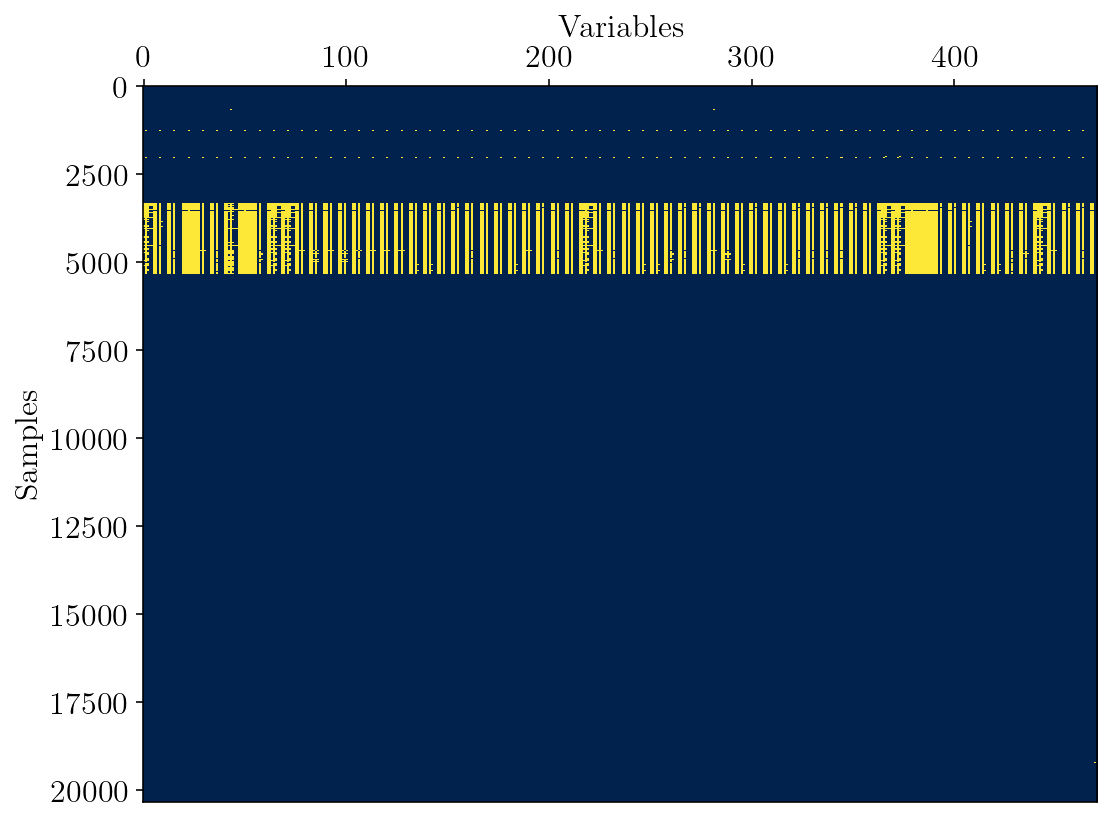

There were 2069 na values in the learning set
The learning set has been successfully cached


In [23]:
variables = ['wind_speed', 'wind_gust', 'wind_bearing', 'temperature', 'humidity', 'pressure', 'air_density']
cache.wind_ls.cache_learning_set(show_na=True, test_set=False, variables=variables)

In [24]:
from sklearn.ensemble import ExtraTreesRegressor

X, y, t = cache.wind_ls.get_learning_set()
xt = ExtraTreesRegressor(n_estimators=1000, max_features='auto').fit(X, y)

In [25]:
fi = xt.feature_importances_.reshape((-1, len(variables)))
mean_fi = np.mean(fi, axis=0)
std_fi = np.std(fi, axis=0)

for f, m, s in zip(variables, mean_fi, std_fi):
    print('{:_<15}{:.2f}%±{:.2f}%'.format(f, 100*m, 100*s))

wind_speed_____0.91%±1.44%
wind_gust______0.49%±1.02%
wind_bearing___0.02%±0.00%
temperature____0.03%±0.01%
humidity_______0.02%±0.01%
pressure_______0.01%±0.00%
air_density____0.01%±0.00%


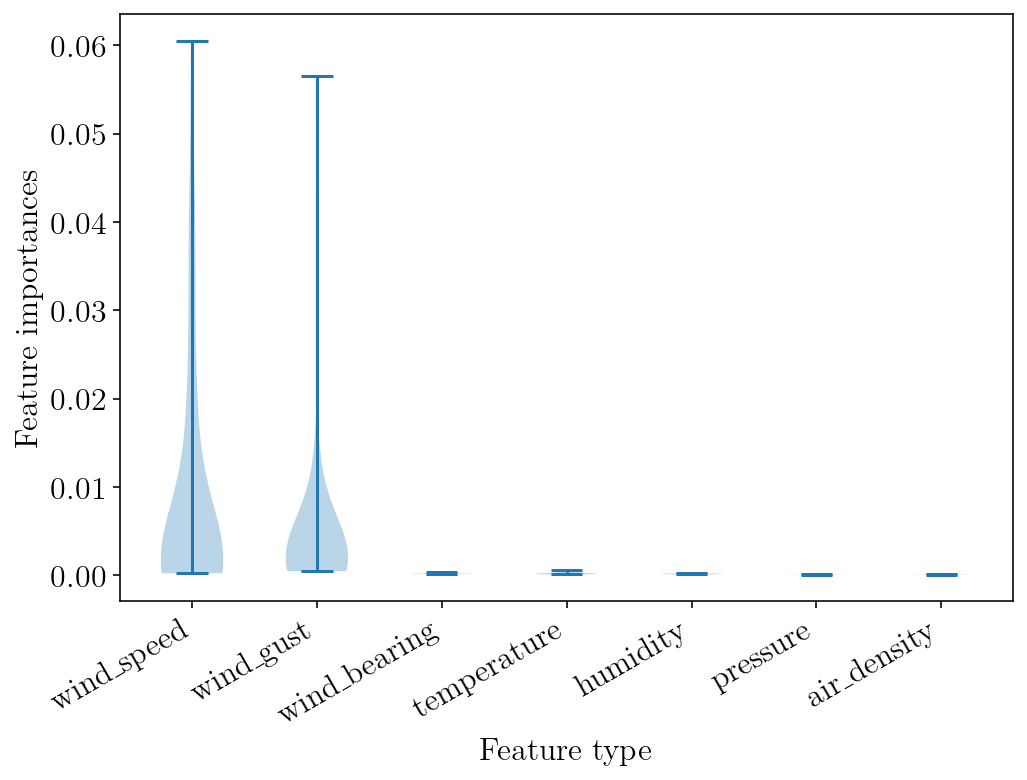

In [26]:
import tools.plot_setup
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.violinplot(fi)
ax.set_xticks(range(1, len(variables) + 1))
ax.set_xticklabels([x.replace('_', '\_') for x in variables])
ax.set_ylabel('Feature importances')
ax.set_xlabel('Feature type')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../products/pdf/feature_importances.pdf')
plt.show()

### Reset learning set

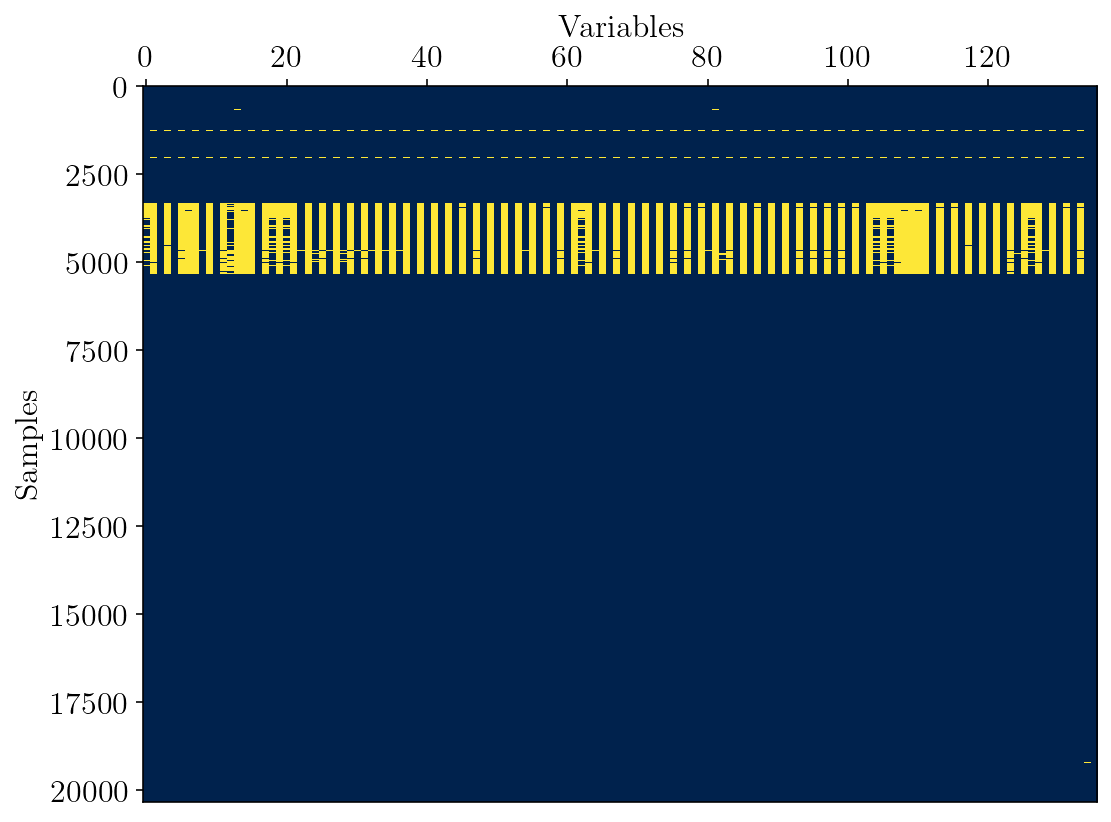

There were 2051 na values in the learning set
The learning set has been successfully cached


In [27]:
variables = ['wind_speed', 'wind_gust']
cache.wind_ls.cache_learning_set(show_na=True, test_set=False, variables=variables)